# Part 3

In [1]:
# Import Dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy import Column, Integer, Float, Date, String, VARCHAR

from time import time
from datetime import datetime

import pymysql
pymysql.install_as_MySQLdb()

# Import Dependencies for charting
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Create engine
engine = create_engine('sqlite:///hawaii.db')

In [3]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Get table names from data base
inspector.get_table_names()

['measures', 'stations']

In [4]:
Base = automap_base()

In [5]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measures', 'stations']

In [7]:
Stations = Base.classes.stations
Measures = Base.classes.measures

In [8]:
# Create Session
session = Session(engine)

In [ ]:
### Precipitation Analysis #############################################################

# Design a query to retrieve the last 12 months of precipitation data.

# Select only the `date` and `prcp` values.

# Load the query results into a Pandas DataFrame and set the index to the date column.

# Plot the results using the DataFrame `plot` method.
 
# Use Pandas to print the summary statistics for the precipitation data.

In [11]:
#Query
precip_qry = session.query(Measures.date, Measures.prcp).filter(Measures.date > "2016-08-25").\
        group_by(Measures.date).all()

In [13]:
# Unpack `date` and `prcp` from results and save into separate lists
prcp_date = [result[0] for result in precip_qry[:len(precip_qry)]]
prcp = [result[1] for result in precip_qry[:len(precip_qry)]]

#Combine lists into a dataframe, and sort by date
prcp_df = pd.DataFrame({'date': prcp_date, 'precipitation': prcp})
prcp_df = prcp_df.sort_values(by = ['date'])

#print top 10 observations
prcp_df.head()

#Doesn't quite seem to be grouping correctly...not sure why

,date,precipitation
0,2016-08-26,0.01
1,2016-08-27,0.12
2,2016-08-28,2.07
3,2016-08-29,0.90
4,2016-08-30,0.05


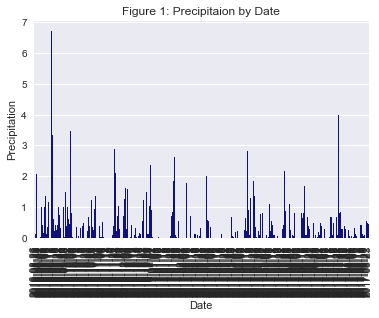

In [16]:
#Create a barplot
sns.set_style('darkgrid')
fig1 = sns.barplot(x='date', y='precipitation', data=prcp_df, color='darkblue')
fig1.set(xlabel='Date', ylabel='Precipitation', title='Figure 1: Precipitaion by Date')
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=90)
#Need to figure out how to specify the number of points between ticks
plt.show()

In [ ]:
### Station Analysis ##################################################################

# Design a query to calculate the total number of stations.

# Design a query to find the most active stations.
#   List the stations and observation counts in descending order
#   Which station has the highest number of observations?

# Design a query to retrieve the last 12 months of temperature observation data (tobs).

# Filter by the station with the highest number of observations.

# Plot the results as a histogram with `bins=12`.

In [17]:
#Design a query to calculate the total number of stations
num_stations = len(session.query(func.count(Measures.station)).group_by(Measures.station).all())
num_stations

9

In [19]:
# Design a query to find the most active stations, in descending order
active_stations = session.query(Measures.station, func.count(Measures.station)).group_by(Measures.station).\
    order_by(func.count(Measures.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [20]:
# List the stations and observation counts in descending order
print(active_stations)

most_active_station = active_stations[0][0]
most_active_count = active_stations[0][1]

# Which station has the highest number of observations?
print("Most active station: " + str(most_active_station))
print("# Observations:      " + str(most_active_count))

[('USC00519281', 2772), ('USC00513117', 2696), ('USC00519397', 2685), ('USC00519523', 2572), ('USC00516128', 2484), ('USC00514830', 1937), ('USC00511918', 1932), ('USC00517948', 683), ('USC00518838', 342)]
Most active station: USC00519281
# Observations:      2772


In [22]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs)
tobs_qry = session.query(Measures.station, Measures.tobs).filter(Measures.date > "2016-08-25").\
        group_by(Measures.date).all()

In [23]:
# Filter by the station with the highest number of observations.
tobs_top_qry = session.query(Measures.station, Measures.tobs)\
        .filter(Measures.date > "2016-08-25", Measures.station == most_active_station)\
        .group_by(Measures.date).all()

In [24]:
top_station_tobs = pd.DataFrame({'temp': [result[1] for result in tobs_top_qry[:len(tobs_top_qry)]]})
top_station_tobs.head()

,temp
0,80
1,75
2,73
3,78
4,77


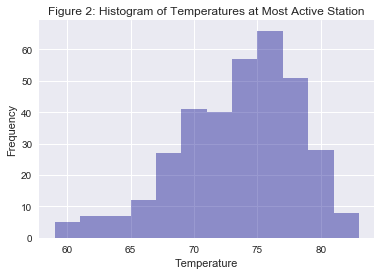

In [25]:
# Plot the results as a histogram with `bins=12`.
sns.set_style('darkgrid')
fig2 = sns.distplot(top_station_tobs['temp'], bins=12, kde=False, color = 'darkblue');
fig2.set(xlabel='Temperature', ylabel='Frequency', title = 'Figure 2: Histogram of Temperatures at Most Active Station')
plt.show()

In [ ]:
### Temperature Analysis #############################################################

# 1. Write a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d`
#    and return the minimum, average, and maximum temperatures for that range of dates.

# 2. Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the 
#    matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

# 3. Plot the min, avg, and max temperature from your previous query as a bar chart.
#   a. Use the average temperature as the bar height.
#   b. Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).


In [26]:
start_date = "2016-08-25"
end_date = "2017-08-25"

In [27]:
def calc_temps(start_date, end_date):
    
    qry = session.query(Measures.date, Measures.tobs).filter(Measures.date >= start_date)\
        .filter(Measures.date <= end_date).group_by(Measures.date).all()
    
    df = pd.DataFrame({'temp': [result[1] for result in qry[:len(qry)]]})
    
    temp_min = df.min()
    temp_avg = df.mean()
    temp_max = df.max()
    
    return {'min_temp':temp_min, 'avg_temp':temp_avg ,'max_temp':temp_max}

In [28]:
trip_temps = calc_temps('2017-05-04', '2017-05-18')
trip_temps

{'avg_temp': temp    71.666667
 dtype: float64, 'max_temp': temp    78
 dtype: int64, 'min_temp': temp    66
 dtype: int64}

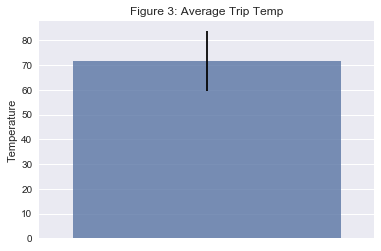

In [29]:
# 3. Plot the min, avg, and max temperature from your previous query as a bar chart.
#   a. Use the average temperature as the bar height.
#   b. Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

fig3 = sns.barplot(y = trip_temps['avg_temp'], yerr = (trip_temps['max_temp']-trip_temps['min_temp']), alpha = 0.8)
fig3.set(ylabel='Temperature', title='Figure 3: Average Trip Temp')
plt.show()